In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib import learn
from sklearn import preprocessing
from sklearn import metrics
from __future__ import print_function
import itertools
#from tensorflow.python.ops import math_ops

%matplotlib inline

In [2]:
#%run ./importWalkingDataConfidence_strongerWts.ipynb
%run ./importWalkingDataConfidence.ipynb
tf.logging.set_verbosity(tf.logging.INFO)

./dataFix.ipynb:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  "from sklearn import model_selection\n",
./dataFix.ipynb:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  {


Dimension of walking test_x  =  (134, 27)
Dimension of walking train_x =  (536, 27)


./dataFix.ipynb:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  {


In [3]:
EMOSCORES

['happier_mu', 'sadder_mu', 'angrier_mu', 'more-afraid_mu']

In [4]:
def get_input_fn(data_x,data_y, LABEL, num_epochs=None, shuffle=True):
  return tf.estimator.inputs.pandas_input_fn(
      x=pd.DataFrame({k: data_x[k].values for k in FEATURESALL_WTS}),
      y = pd.DataFrame(data_y[LABEL].values),
      num_epochs=num_epochs,
      shuffle=shuffle)

In [5]:
embedded_ffp_column = tf.contrib.layers.embedding_column(
    tf.contrib.layers.sparse_column_with_integerized_feature("FFPType", 7, combiner=None, dtype=tf.int64), dimension = 7)
sparse_ffp_column =  tf.contrib.layers.sparse_column_with_integerized_feature("FFPType", 7, combiner=None, dtype=tf.int64)
# Continuous columns- frontKneesAngle	rearKneesAngle	frontAnkle	rearAnkle	frontHipsAngle
bodyZ = tf.feature_column.numeric_column("bodyAngleZ")
frontK = tf.feature_column.numeric_column("frontKneesAngle")
rearK = tf.feature_column.numeric_column("rearKneesAngle")
frontA = tf.feature_column.numeric_column("frontAnkle")
rearA = tf.feature_column.numeric_column("rearAnkle")
frontH = tf.feature_column.numeric_column("frontHipsAngle")
rearH = tf.feature_column.numeric_column("rearHipsAngle")
swingFtHt = tf.feature_column.numeric_column("swingFtHeight")
speed = tf.feature_column.numeric_column("speed")
gaitTime = tf.feature_column.numeric_column("gaitDuration")

feature_cols = [bodyZ, frontK, rearK, frontA, rearA, frontH, rearH, swingFtHt, speed, gaitTime, embedded_ffp_column]
#lin_feature_cols = [bodyZ, frontK, rearK, frontA, rearA, frontH, rearH, swingFtHt, speed, gaitTime]
#lin_feature_cols = [sparse_ffp_column]
#lin_feature_cols = [bodyZ, swingFtHt, speed, gaitTime, sparse_ffp_column]
lin_feature_cols = [bodyZ, swingFtHt, speed, gaitTime]
#lin_feature_cols = [bodyZ, frontK, rearK, frontA, rearA, frontH, rearH, swingFtHt, speed, gaitTime, sparse_ffp_column]

In [6]:
LABEL_ID = 3;
LABEL = EMOSCORES[LABEL_ID]
WT_COL = WTS_LABEL[LABEL_ID]

In [7]:
LABEL

'more-afraid_mu'

In [8]:
# validation_metrics = {
#     "rmse":
#         tf.metrics.root_mean_squared_error(labels = pd.DataFrame(y_test[LABEL].values),predictions=y_predicted)
# }

In [9]:
validation_monitor = tf.contrib.learn.monitors.ValidationMonitor(
input_fn=get_input_fn(X_test_all_wts, y_test, LABEL, num_epochs=1, shuffle=False),
    every_n_steps=50,
    early_stopping_metric="loss",
    early_stopping_metric_minimize=True,
    early_stopping_rounds=500) #200 500 1000
    #metrics=validation_metrics)

Instructions for updating:
Monitors are deprecated. Please use tf.train.SessionRunHook.


In [10]:
# Build a wide + deep model
model_dir_name="/DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001"
#model_dir_name="/DNNNew/DNNScared/scared_ConfidenceCRELUPlus2Layer100_100UnitsDropout02EarlyStopLR001_8020Data"

regressor = tf.contrib.learn.DNNLinearCombinedRegressor(linear_feature_columns = lin_feature_cols,
   dnn_feature_columns=feature_cols, dnn_hidden_units=[100,100],  model_dir=model_dir_name, weight_column_name = WT_COL,
     dnn_optimizer = tf.train.AdamOptimizer(
       learning_rate=0.001), dnn_dropout =0.2, config=tf.contrib.learn.RunConfig(save_checkpoints_secs=1), dnn_activation_fn = tf.nn.relu)

#regressor = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols, hidden_units=[100,100],  model_dir=model_dir_name, weight_column_name = WT_COL,
    #optimizer = tf.train.AdamOptimizer(
      #learning_rate=0.001), dropout =0.2, config=tf.contrib.learn.RunConfig(save_checkpoints_secs=1), activation_fn = tf.nn.crelu)

#tf.contrib.layers.xavier_initializer(uniform=True) # this seems more useful for vision stuff where there is lot of fan_in and fan_out

Instructions for updating:
Please set fix_global_step_increment_bug=True and update training steps in your pipeline. See pydoc for details.
INFO:tensorflow:Using config: {'_num_worker_replicas': 0, '_environment': 'local', '_keep_checkpoint_every_n_hours': 10000, '_save_summary_steps': 100, '_num_ps_replicas': 0, '_session_config': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_keep_checkpoint_max': 5, '_is_chief': True, '_model_dir': '/DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001', '_evaluation_master': '', '_save_checkpoints_secs': 1, '_tf_random_seed': None, '_save_checkpoints_steps': None, '_log_step_count_steps': 100, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000000000E5366D8>, '_task_type': None, '_master': ''}


In [11]:
# Train.
regressor.fit(input_fn=get_input_fn(X_train_all_wts, y_train, LABEL, num_epochs=None, shuffle=True),steps=200000, monitors=[validation_monitor]) #2000000

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 2 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:step = 2, loss = 410.816
INFO:tensorflow:Saving checkpoints for 4 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 6 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 8 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 20 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-52
INFO:tensorflow:Finished evaluation at 2018-02-10-23:10:48
INFO:tensorflow:Saving dict for global step 52: global_step = 52, loss = 456.552
INFO:tensorflow:Validation (step 51): global_step = 52, loss = 456.552
INFO:tensorflow:Saving checkpoints for 54 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 56 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 58 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 60 into /DNNNew/DNNScared/wideAndDeep/scared_

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-102
INFO:tensorflow:Finished evaluation at 2018-02-10-23:11:20
INFO:tensorflow:Saving dict for global step 102: global_step = 102, loss = 158.877
INFO:tensorflow:Validation (step 101): global_step = 102, loss = 158.877
INFO:tensorflow:Saving checkpoints for 104 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 106 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 108 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 110 into /DNNNew/DNNScared/wideAndDee

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-152
INFO:tensorflow:Finished evaluation at 2018-02-10-23:11:50
INFO:tensorflow:Saving dict for global step 152: global_step = 152, loss = 62.6495
INFO:tensorflow:Validation (step 151): global_step = 152, loss = 62.6495
INFO:tensorflow:Saving checkpoints for 154 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 156 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 158 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 160 into /DNNNew/DNNScared/wideAndDee

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-202
INFO:tensorflow:Finished evaluation at 2018-02-10-23:12:21
INFO:tensorflow:Saving dict for global step 202: global_step = 202, loss = 49.3083
INFO:tensorflow:Validation (step 201): global_step = 202, loss = 49.3083
INFO:tensorflow:step = 202, loss = 26.5224 (118.155 sec)
INFO:tensorflow:Saving checkpoints for 204 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 206 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 208 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Sav

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-252
INFO:tensorflow:Finished evaluation at 2018-02-10-23:12:52
INFO:tensorflow:Saving dict for global step 252: global_step = 252, loss = 41.7759
INFO:tensorflow:Validation (step 251): global_step = 252, loss = 41.7759
INFO:tensorflow:Saving checkpoints for 254 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 256 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 258 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 260 into /DNNNew/DNNScared/wideAndDee

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-302
INFO:tensorflow:Finished evaluation at 2018-02-10-23:13:24
INFO:tensorflow:Saving dict for global step 302: global_step = 302, loss = 38.8302
INFO:tensorflow:Validation (step 301): global_step = 302, loss = 38.8302
INFO:tensorflow:Saving checkpoints for 304 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 306 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 308 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 310 into /DNNNew/DNNScared/wideAndDee

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-352
INFO:tensorflow:Finished evaluation at 2018-02-10-23:13:54
INFO:tensorflow:Saving dict for global step 352: global_step = 352, loss = 35.606
INFO:tensorflow:Validation (step 351): global_step = 352, loss = 35.606
INFO:tensorflow:Saving checkpoints for 354 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 356 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 358 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 360 into /DNNNew/DNNScared/wideAndDeep/

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-402
INFO:tensorflow:Finished evaluation at 2018-02-10-23:14:27
INFO:tensorflow:Saving dict for global step 402: global_step = 402, loss = 34.2464
INFO:tensorflow:Validation (step 401): global_step = 402, loss = 34.2464
INFO:tensorflow:step = 402, loss = 19.7957 (125.447 sec)
INFO:tensorflow:Saving checkpoints for 404 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 406 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 408 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Sav

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-452
INFO:tensorflow:Finished evaluation at 2018-02-10-23:15:00
INFO:tensorflow:Saving dict for global step 452: global_step = 452, loss = 32.4762
INFO:tensorflow:Validation (step 451): global_step = 452, loss = 32.4762
INFO:tensorflow:Saving checkpoints for 454 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 456 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 458 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 460 into /DNNNew/DNNScared/wideAndDee

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-502
INFO:tensorflow:Finished evaluation at 2018-02-10-23:15:31
INFO:tensorflow:Saving dict for global step 502: global_step = 502, loss = 32.8745
INFO:tensorflow:Validation (step 501): global_step = 502, loss = 32.8745
INFO:tensorflow:Saving checkpoints for 504 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 506 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 508 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 510 into /DNNNew/DNNScared/wideAndDee

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-552
INFO:tensorflow:Finished evaluation at 2018-02-10-23:16:02
INFO:tensorflow:Saving dict for global step 552: global_step = 552, loss = 30.7946
INFO:tensorflow:Validation (step 551): global_step = 552, loss = 30.7946
INFO:tensorflow:Saving checkpoints for 554 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 556 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 558 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 560 into /DNNNew/DNNScared/wideAndDee

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-602
INFO:tensorflow:Finished evaluation at 2018-02-10-23:16:32
INFO:tensorflow:Saving dict for global step 602: global_step = 602, loss = 30.3193
INFO:tensorflow:Validation (step 601): global_step = 602, loss = 30.3193
INFO:tensorflow:step = 602, loss = 16.3366 (125.429 sec)
INFO:tensorflow:Saving checkpoints for 604 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 606 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 608 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Sav

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-652
INFO:tensorflow:Finished evaluation at 2018-02-10-23:17:01
INFO:tensorflow:Saving dict for global step 652: global_step = 652, loss = 30.2173
INFO:tensorflow:Validation (step 651): global_step = 652, loss = 30.2173
INFO:tensorflow:Saving checkpoints for 654 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 656 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 658 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 660 into /DNNNew/DNNScared/wideAndDee

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-702
INFO:tensorflow:Finished evaluation at 2018-02-10-23:17:33
INFO:tensorflow:Saving dict for global step 702: global_step = 702, loss = 29.3012
INFO:tensorflow:Validation (step 701): global_step = 702, loss = 29.3012
INFO:tensorflow:Saving checkpoints for 704 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 706 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 708 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 710 into /DNNNew/DNNScared/wideAndDee

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-752
INFO:tensorflow:Finished evaluation at 2018-02-10-23:18:05
INFO:tensorflow:Saving dict for global step 752: global_step = 752, loss = 29.1072
INFO:tensorflow:Validation (step 751): global_step = 752, loss = 29.1072
INFO:tensorflow:Saving checkpoints for 754 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 756 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 758 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 760 into /DNNNew/DNNScared/wideAndDee

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-802
INFO:tensorflow:Finished evaluation at 2018-02-10-23:18:38
INFO:tensorflow:Saving dict for global step 802: global_step = 802, loss = 29.1182
INFO:tensorflow:Validation (step 801): global_step = 802, loss = 29.1182
INFO:tensorflow:step = 802, loss = 16.5269 (125.988 sec)
INFO:tensorflow:Saving checkpoints for 804 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 806 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 808 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Sav

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-852
INFO:tensorflow:Finished evaluation at 2018-02-10-23:19:11
INFO:tensorflow:Saving dict for global step 852: global_step = 852, loss = 28.7465
INFO:tensorflow:Validation (step 851): global_step = 852, loss = 28.7465
INFO:tensorflow:Saving checkpoints for 854 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 856 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 858 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 860 into /DNNNew/DNNScared/wideAndDee

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-902
INFO:tensorflow:Finished evaluation at 2018-02-10-23:19:41
INFO:tensorflow:Saving dict for global step 902: global_step = 902, loss = 26.2695
INFO:tensorflow:Validation (step 901): global_step = 902, loss = 26.2695
INFO:tensorflow:Saving checkpoints for 904 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 906 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 908 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 910 into /DNNNew/DNNScared/wideAndDee

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-950
INFO:tensorflow:Finished evaluation at 2018-02-10-23:20:11
INFO:tensorflow:Saving dict for global step 950: global_step = 950, loss = 28.9012
INFO:tensorflow:Validation (step 951): global_step = 950, loss = 28.9012
INFO:tensorflow:Saving checkpoints for 954 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 956 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 958 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 960 into /DNNNew/DNNScared/wideAndDee

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1002
INFO:tensorflow:Finished evaluation at 2018-02-10-23:20:41
INFO:tensorflow:Saving dict for global step 1002: global_step = 1002, loss = 26.7908
INFO:tensorflow:Validation (step 1001): global_step = 1002, loss = 26.7908
INFO:tensorflow:step = 1002, loss = 14.9594 (122.479 sec)
INFO:tensorflow:Saving checkpoints for 1004 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1006 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1008 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tenso

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1052
INFO:tensorflow:Finished evaluation at 2018-02-10-23:21:11
INFO:tensorflow:Saving dict for global step 1052: global_step = 1052, loss = 28.0703
INFO:tensorflow:Validation (step 1051): global_step = 1052, loss = 28.0703
INFO:tensorflow:Saving checkpoints for 1054 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1056 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1058 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1060 into /DNNNew/DNNScared/w

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1102
INFO:tensorflow:Finished evaluation at 2018-02-10-23:21:41
INFO:tensorflow:Saving dict for global step 1102: global_step = 1102, loss = 27.6153
INFO:tensorflow:Validation (step 1101): global_step = 1102, loss = 27.6153
INFO:tensorflow:Saving checkpoints for 1104 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1106 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1108 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1110 into /DNNNew/DNNScared/w

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1152
INFO:tensorflow:Finished evaluation at 2018-02-10-23:22:12
INFO:tensorflow:Saving dict for global step 1152: global_step = 1152, loss = 27.205
INFO:tensorflow:Validation (step 1151): global_step = 1152, loss = 27.205
INFO:tensorflow:Saving checkpoints for 1154 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1156 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1158 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1160 into /DNNNew/DNNScared/wid

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1202
INFO:tensorflow:Finished evaluation at 2018-02-10-23:22:43
INFO:tensorflow:Saving dict for global step 1202: global_step = 1202, loss = 27.5892
INFO:tensorflow:Validation (step 1201): global_step = 1202, loss = 27.5892
INFO:tensorflow:step = 1202, loss = 13.7649 (122.671 sec)
INFO:tensorflow:Saving checkpoints for 1204 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1206 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1208 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tenso

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1252
INFO:tensorflow:Finished evaluation at 2018-02-10-23:23:15
INFO:tensorflow:Saving dict for global step 1252: global_step = 1252, loss = 26.026
INFO:tensorflow:Validation (step 1251): global_step = 1252, loss = 26.026
INFO:tensorflow:Saving checkpoints for 1254 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1256 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1258 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1260 into /DNNNew/DNNScared/wid

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1302
INFO:tensorflow:Finished evaluation at 2018-02-10-23:23:45
INFO:tensorflow:Saving dict for global step 1302: global_step = 1302, loss = 25.9985
INFO:tensorflow:Validation (step 1301): global_step = 1302, loss = 25.9985
INFO:tensorflow:Saving checkpoints for 1304 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1306 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1308 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1310 into /DNNNew/DNNScared/w

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1352
INFO:tensorflow:Finished evaluation at 2018-02-10-23:24:17
INFO:tensorflow:Saving dict for global step 1352: global_step = 1352, loss = 25.8468
INFO:tensorflow:Validation (step 1351): global_step = 1352, loss = 25.8468
INFO:tensorflow:Saving checkpoints for 1354 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1356 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1358 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1360 into /DNNNew/DNNScared/w

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1402
INFO:tensorflow:Finished evaluation at 2018-02-10-23:24:48
INFO:tensorflow:Saving dict for global step 1402: global_step = 1402, loss = 24.9764
INFO:tensorflow:Validation (step 1401): global_step = 1402, loss = 24.9764
INFO:tensorflow:step = 1402, loss = 16.3633 (124.715 sec)
INFO:tensorflow:Saving checkpoints for 1404 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1406 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1408 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tenso

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1452
INFO:tensorflow:Finished evaluation at 2018-02-10-23:25:18
INFO:tensorflow:Saving dict for global step 1452: global_step = 1452, loss = 25.617
INFO:tensorflow:Validation (step 1451): global_step = 1452, loss = 25.617
INFO:tensorflow:Saving checkpoints for 1454 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1456 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1458 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1460 into /DNNNew/DNNScared/wid

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1502
INFO:tensorflow:Finished evaluation at 2018-02-10-23:25:51
INFO:tensorflow:Saving dict for global step 1502: global_step = 1502, loss = 24.2103
INFO:tensorflow:Validation (step 1501): global_step = 1502, loss = 24.2103
INFO:tensorflow:Saving checkpoints for 1504 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1506 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1508 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1510 into /DNNNew/DNNScared/w

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation at 2018-02-10-23:26:19
INFO:tensorflow:Restoring parameters from /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1552
INFO:tensorflow:Finished evaluation at 2018-02-10-23:26:20
INFO:tensorflow:Saving dict for global step 1552: global_step = 1552, loss = 25.1423
INFO:tensorflow:Validation (step 1551): global_step = 1552, loss = 25.1423
INFO:tensorflow:Saving checkpoints for 1554 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for

  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\contrib\learn\python\learn\estimators\dnn_linear_combined.py", line 369, in _dnn_linear_combined_model_fn
    logits=logits)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\contrib\learn\python\learn\estimators\head.py", line 732, in create_model_fn_ops
    enable_centered_bias=self._enable_centered_bias)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\contrib\learn\python\learn\estimators\head.py", line 637, in _create_model_fn_ops
    weight_tensor = _weight_tensor(features, weight_column_name)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\contrib\learn\python\learn\estimators\head.py", line 1760, in _weight_tensor
    weight_column_name, shape)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\platform\tf_logging.py", line 90, in warning
    _logger.warning(msg, *args, **kwargs)
Me

INFO:tensorflow:Restoring parameters from /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1602
INFO:tensorflow:Finished evaluation at 2018-02-10-23:26:52
INFO:tensorflow:Saving dict for global step 1602: global_step = 1602, loss = 25.3953
INFO:tensorflow:Validation (step 1601): global_step = 1602, loss = 25.3953
INFO:tensorflow:step = 1602, loss = 13.8587 (123.886 sec)
INFO:tensorflow:Saving checkpoints for 1604 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1606 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1608 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tenso

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1652
INFO:tensorflow:Finished evaluation at 2018-02-10-23:27:25
INFO:tensorflow:Saving dict for global step 1652: global_step = 1652, loss = 25.9032
INFO:tensorflow:Validation (step 1651): global_step = 1652, loss = 25.9032
INFO:tensorflow:Saving checkpoints for 1654 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1656 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1658 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1660 into /DNNNew/DNNScared/w

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1702
INFO:tensorflow:Finished evaluation at 2018-02-10-23:27:54
INFO:tensorflow:Saving dict for global step 1702: global_step = 1702, loss = 24.8231
INFO:tensorflow:Validation (step 1701): global_step = 1702, loss = 24.8231
INFO:tensorflow:Saving checkpoints for 1704 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1706 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1708 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1710 into /DNNNew/DNNScared/w

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1752
INFO:tensorflow:Finished evaluation at 2018-02-10-23:28:24
INFO:tensorflow:Saving dict for global step 1752: global_step = 1752, loss = 26.7345
INFO:tensorflow:Validation (step 1751): global_step = 1752, loss = 26.7345
INFO:tensorflow:Saving checkpoints for 1754 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1756 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1758 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1760 into /DNNNew/DNNScared/w

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1802
INFO:tensorflow:Finished evaluation at 2018-02-10-23:28:56
INFO:tensorflow:Saving dict for global step 1802: global_step = 1802, loss = 25.071
INFO:tensorflow:Validation (step 1801): global_step = 1802, loss = 25.071
INFO:tensorflow:step = 1802, loss = 12.5197 (124.480 sec)
INFO:tensorflow:Saving checkpoints for 1804 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1806 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1808 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorf

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1852
INFO:tensorflow:Finished evaluation at 2018-02-10-23:29:27
INFO:tensorflow:Saving dict for global step 1852: global_step = 1852, loss = 26.512
INFO:tensorflow:Validation (step 1851): global_step = 1852, loss = 26.512
INFO:tensorflow:Saving checkpoints for 1854 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1856 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1858 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1860 into /DNNNew/DNNScared/wid

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1902
INFO:tensorflow:Finished evaluation at 2018-02-10-23:30:01
INFO:tensorflow:Saving dict for global step 1902: global_step = 1902, loss = 25.433
INFO:tensorflow:Validation (step 1901): global_step = 1902, loss = 25.433
INFO:tensorflow:Saving checkpoints for 1904 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1906 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1908 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1910 into /DNNNew/DNNScared/wid

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1952
INFO:tensorflow:Finished evaluation at 2018-02-10-23:30:34
INFO:tensorflow:Saving dict for global step 1952: global_step = 1952, loss = 25.2458
INFO:tensorflow:Validation (step 1951): global_step = 1952, loss = 25.2458
INFO:tensorflow:Saving checkpoints for 1954 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1956 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1958 into /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1960 into /DNNNew/DNNScared/w

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-2002
INFO:tensorflow:Finished evaluation at 2018-02-10-23:31:05
INFO:tensorflow:Saving dict for global step 2002: global_step = 2002, loss = 24.5398
INFO:tensorflow:Validation (step 2001): global_step = 2002, loss = 24.5398
INFO:tensorflow:Stopping. Best step: 1501 with loss = 24.210344314575195.
INFO:tensorflow:step = 2002, loss = 12.2127 (128.355 sec)
INFO:tensorflow:Loss for final step: 12.2127.


DNNLinearCombinedRegressor(params={'linear_optimizer': None, 'dnn_hidden_units': [100, 100], 'dnn_dropout': 0.2, 'dnn_activation_fn': <function relu at 0x000000000909E158>, 'linear_feature_columns': [_NumericColumn(key='bodyAngleZ', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='swingFtHeight', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='speed', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='gaitDuration', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)], 'input_layer_partitioner': None, 'dnn_feature_columns': [_NumericColumn(key='bodyAngleZ', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='frontKneesAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='rearKneesAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _Nume

In [12]:
 ev = regressor.evaluate(
     input_fn=get_input_fn(X_test_all_wts, y_test, LABEL, num_epochs=1, shuffle=False))#,metrics=validation_metrics)
print('MSE (tensorflow): {0:f}'.format(ev['loss']))

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation at 2018-02-10-23:31:06


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-2002
INFO:tensorflow:Finished evaluation at 2018-02-10-23:31:06
INFO:tensorflow:Saving dict for global step 2002: global_step = 2002, loss = 24.5398
MSE (tensorflow): 24.539806


In [13]:
predictions = regressor.predict_scores(input_fn=get_input_fn(X_test_all_wts, y_test, LABEL, num_epochs=1, shuffle=False))
y_predicted = list(itertools.islice(predictions,y_test[LABEL].size))

INFO:tensorflow:Restoring parameters from /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-2002


In [14]:
y_predicted

[22.64864,
 28.539658,
 21.825146,
 22.731932,
 20.962626,
 23.146667,
 30.600264,
 29.324713,
 19.416929,
 24.859547,
 27.552109,
 30.089163,
 25.099344,
 29.657446,
 26.429424,
 25.936104,
 23.540495,
 28.544533,
 27.34763,
 21.75128,
 31.069822,
 25.346006,
 27.423565,
 23.164503,
 26.109591,
 24.659349,
 22.3678,
 24.894814,
 28.968493,
 23.811184,
 30.188774,
 25.246984,
 24.807201,
 21.620035,
 26.244455,
 28.065708,
 27.228542,
 23.312937,
 20.286499,
 28.705189,
 20.538294,
 27.975737,
 30.536449,
 25.195068,
 24.742884,
 24.088345,
 24.107849,
 24.241072,
 30.053371,
 23.998459,
 28.11351,
 21.497917,
 20.666679,
 31.028624,
 29.043524,
 25.788265,
 29.973965,
 22.116474,
 27.452971,
 29.832764,
 25.096287,
 24.156187,
 30.572651,
 25.796175,
 25.847713,
 26.098564,
 25.621672,
 32.255959,
 23.924583,
 23.874275,
 28.127337,
 21.973,
 20.516087,
 21.430634,
 23.142818,
 26.62306,
 31.208967,
 27.096159,
 25.695578,
 21.925095,
 22.082037,
 27.852005,
 29.825453,
 22.956879,
 2

In [15]:
# Score with sklearn.
score_sklearn = metrics.mean_squared_error(y_test[LABEL].values,y_predicted)
print('MSE (sklearn): {0:f}'.format(score_sklearn))
r2_score = metrics.r2_score(y_test[LABEL].values, y_predicted)
print('R2 (sklearn): {0:f}'.format(r2_score))
# Score with sklearn.
score_sklearn_wtd = metrics.mean_squared_error(y_test[LABEL].values,y_predicted,sample_weight=X_test_all_wts[WT_COL].values)
print('MSE WTD (sklearn): {0:f}'.format(score_sklearn_wtd))
r2_score_wtd = metrics.r2_score(y_test[LABEL].values, y_predicted, sample_weight=X_test_all_wts[WT_COL].values)
print('R2 WTD (sklearn): {0:f}'.format(r2_score_wtd))

MSE (sklearn): 28.764512
R2 (sklearn): 0.172842
MSE WTD (sklearn): 26.185498
R2 WTD (sklearn): 0.218091


In [16]:
predicted_name ="predicted_"+LABEL

In [17]:
predicted_name ="predicted_"+LABEL
y_hat = pd.DataFrame(y_predicted, columns=[predicted_name], index=y_test[LABEL].index) 

In [18]:
y_all = pd.concat([y_hat, y_test[LABEL], y_test[EMOCONFIDENCE_INV[LABEL_ID]], y_test["gif_id"]], axis=1) #gif id is only for debuggingK

In [19]:
y_all_sorted = y_all.sort_values(EMOSCORES[LABEL_ID],ascending=[True])

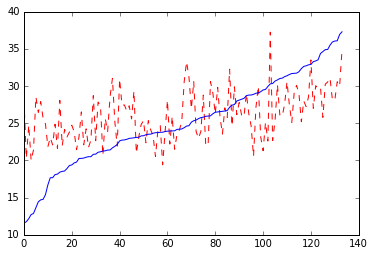

In [20]:
plt.figure()
plt.plot(y_all_sorted[predicted_name].values,'r--',y_all_sorted[LABEL].values,'b')

In [21]:
regressor.get_params()

{'params': {'dnn_activation_fn': <function tensorflow.python.ops.gen_nn_ops.relu>,
  'dnn_dropout': 0.2,
  'dnn_feature_columns': [_NumericColumn(key='bodyAngleZ', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
   _NumericColumn(key='frontKneesAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
   _NumericColumn(key='rearKneesAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
   _NumericColumn(key='frontAnkle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
   _NumericColumn(key='rearAnkle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
   _NumericColumn(key='frontHipsAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
   _NumericColumn(key='rearHipsAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
   _NumericColumn(key='swingFtHeight', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)

In [22]:
ev_train = regressor.evaluate(
     input_fn=get_input_fn(X_train_all_wts, y_train, LABEL, num_epochs=1, shuffle=False))#,metrics=validation_metrics)
print('MSE train (tensorflow): {0:f}'.format(ev_train['loss']))
train_predictions = regressor.predict_scores(input_fn=get_input_fn(X_train_all_wts, y_train, LABEL, num_epochs=1, shuffle=False))
y_predicted_train = list(itertools.islice(train_predictions,y_train[LABEL].size))

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation at 2018-02-10-23:31:10
INFO:tensorflow:Restoring parameters from /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-2002
INFO:tensorflow:Finished evaluation at 2018-02-10-23:31:11
INFO:tensorflow:Saving dict for global step 2002: global_step = 2002, loss = 18.4125
MSE train (tensorflow): 18.412451
INFO:tensorflow:Restoring parameters from /DNNNew/DNNScared/wideAndDeep/scared_wideMotionBodyAndDeepAll_ConfidenceRELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-2002


In [23]:
# Score with sklearn.
score_sklearn_train = metrics.mean_squared_error(y_train[LABEL].values,y_predicted_train)
print('MSE train (sklearn): {0:f}'.format(score_sklearn_train))
r2_score_train = metrics.r2_score(y_train[LABEL].values, y_predicted_train)
print('R2 train (sklearn): {0:f}'.format(r2_score_train))
# Score with sklearn.
score_sklearn_wtd_train = metrics.mean_squared_error(y_train[LABEL].values,y_predicted_train,sample_weight=X_train_all_wts[WT_COL].values)
print('MSE WTD train (sklearn): {0:f}'.format(score_sklearn_wtd_train))
r2_score_wtd_train = metrics.r2_score(y_train[LABEL].values, y_predicted_train, sample_weight=X_train_all_wts[WT_COL].values)
print('R2 WTD train (sklearn): {0:f}'.format(r2_score_wtd_train))

MSE train (sklearn): 20.229040
R2 train (sklearn): 0.368987
MSE WTD train (sklearn): 18.827824
R2 WTD train (sklearn): 0.413355


Populating the interactive namespace from numpy and matplotlib


C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


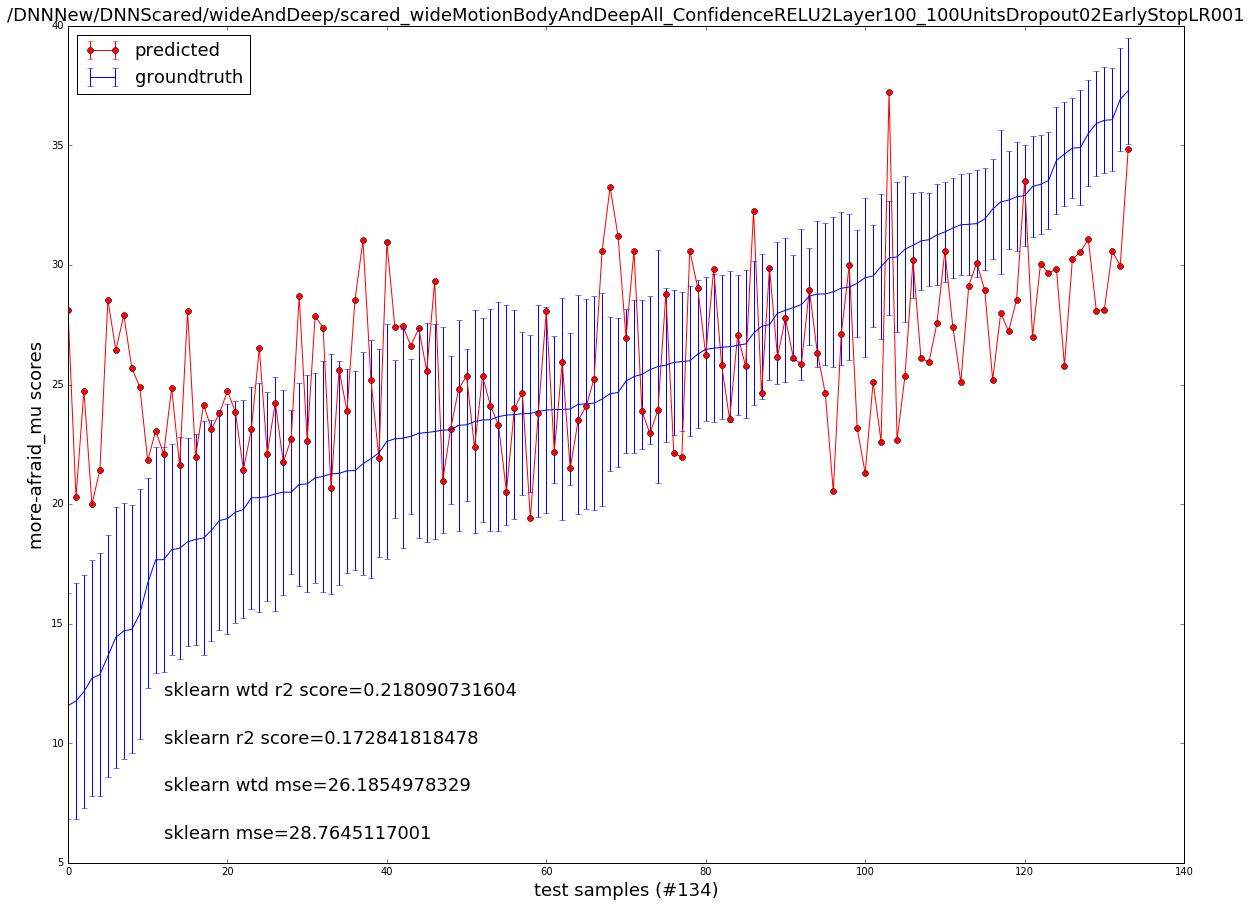

In [24]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 15)
ax =plt.figure()
x = np.arange(0, y_all_sorted[predicted_name].size, 1)
plt.errorbar(x,y_all_sorted[predicted_name].values,yerr=0,fmt='r-o',label="predicted")
plt.errorbar(x,y_all_sorted[LABEL].values,yerr=y_all_sorted[EMOCONFIDENCE_INV[LABEL_ID]],fmt='b',label="groundtruth")
plt.title(model_dir_name,fontsize=18)
plt.xlabel('test samples (#'+str(y_test[LABEL].size)+')',fontsize=18)
plt.ylabel(LABEL +' scores',fontsize=18)
pylab.legend(loc='upper left', fontsize=18)
plt.text(12,12, 'sklearn wtd r2 score='+str(r2_score_wtd), fontsize=18)
plt.text(12,10, 'sklearn r2 score='+str(r2_score), fontsize=18)
plt.text(12,8, 'sklearn wtd mse='+str(score_sklearn_wtd), fontsize=18)
plt.text(12,6, 'sklearn mse='+str(score_sklearn), fontsize=18)
plt.show()
fig_name = model_dir_name + "/testPrediction.pdf"
ax.savefig(fig_name) 

In [25]:
predicted_name_train ="predicted_"+LABEL+"_train"
y_hat_train = pd.DataFrame(y_predicted_train, columns=[predicted_name_train], index=y_train[LABEL].index) 
y_all_train = pd.concat([y_hat_train, y_train[LABEL], y_train[EMOCONFIDENCE_INV[LABEL_ID]], y_train["gif_id"]], axis=1) #gif id is only for debugging
y_all_sorted_train = y_all_train.sort_values(EMOSCORES[LABEL_ID],ascending=[True])

Populating the interactive namespace from numpy and matplotlib


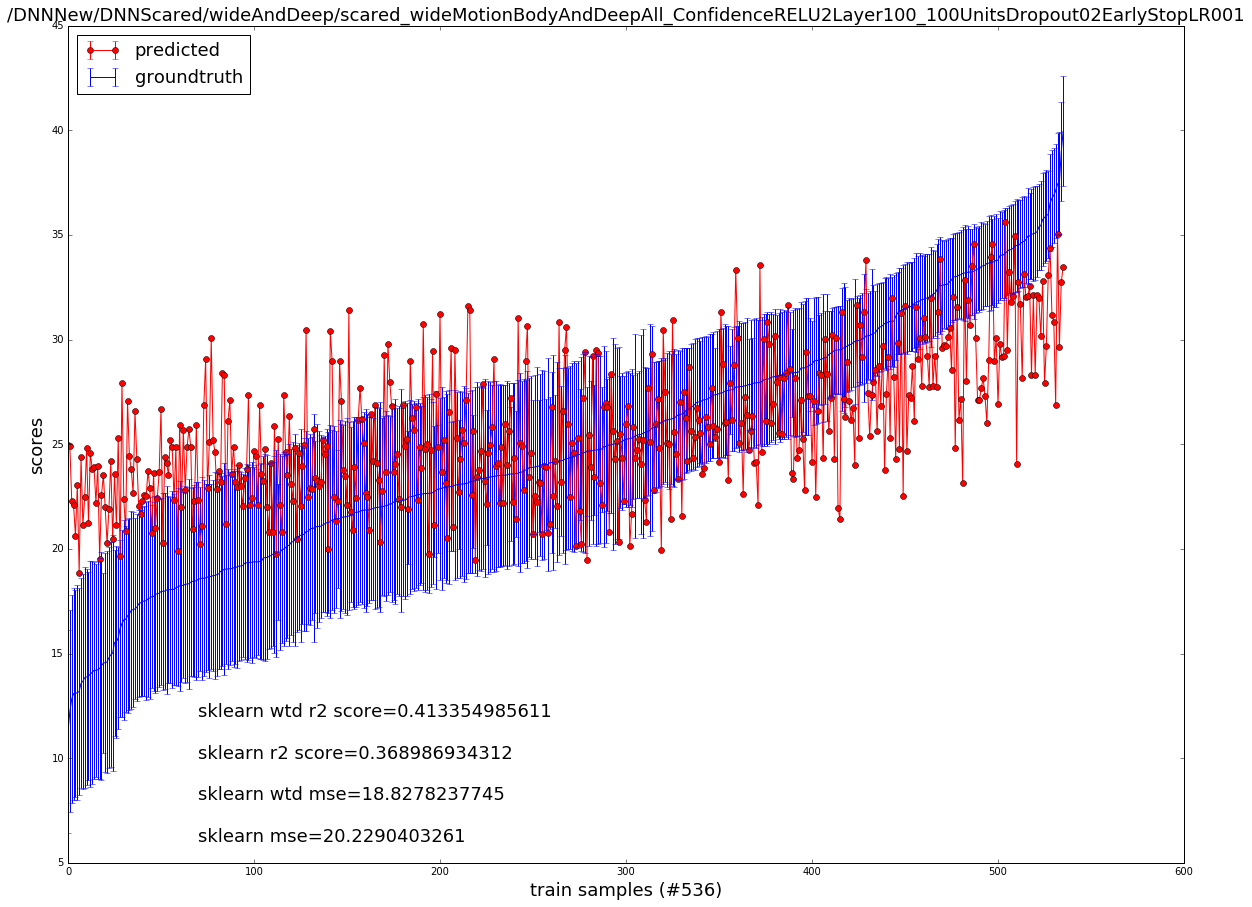

In [26]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 15)
ax =plt.figure()
x = np.arange(0, y_all_sorted_train[predicted_name_train].size, 1)
plt.errorbar(x,y_all_sorted_train[predicted_name_train].values,yerr=0,fmt='r-o',label="predicted")
plt.errorbar(x,y_all_sorted_train[LABEL].values,yerr=y_all_sorted_train[EMOCONFIDENCE_INV[LABEL_ID]],fmt='b',label="groundtruth")
plt.title(model_dir_name,fontsize=18)
plt.xlabel('train samples (#'+str(y_train[LABEL].size)+')',fontsize=18)
plt.ylabel('scores',fontsize=18)
pylab.legend(loc='upper left', fontsize=18)
plt.text(70,12, 'sklearn wtd r2 score='+str(r2_score_wtd_train), fontsize=18)
plt.text(70,10, 'sklearn r2 score='+str(r2_score_train), fontsize=18)
plt.text(70,8, 'sklearn wtd mse='+str(score_sklearn_wtd_train), fontsize=18)
plt.text(70,6, 'sklearn mse='+str(score_sklearn_train), fontsize=18)
plt.show()
fig_name = model_dir_name + "/trainPrediction.pdf"
ax.savefig(fig_name) 